## Imports

In [34]:
import pandas as pd
import numpy as np
from scipy import sparse
import timeit
import matplotlib.pyplot as plt

## load csv into dense matrix, then converts it to sparse matrix
If "res/sparse_training.data" exists, **DO NOT** run cell as it will take awhile

In [ ]:
def load_matrix():
    dense_matrix = np.zeros(shape=(21, 61188), dtype=np.int16)
    with open('../res/training.csv', 'r') as train_stream:
        for i, line in enumerate(train_stream):
            line_int = np.array(list(map(int, line.split(','))), dtype=np.int16)
            doc_label = line_int[-1]
            dense_matrix[doc_label] += line_int[1:-1]
            print(i)
        sparse_training = sparse.csr_matrix(dense_matrix)
        sparse.save_npz('../res/sparse_training.data',sparse_training)
        
# load_matrix()

## load the sparse matrix

In [35]:
sparse_training_data = sparse.load_npz('../res/sparse_training.data.npz')
# print(sparse_training_data[21, 3])  
print(sparse_training_data)

  (1, 0)	9
  (1, 1)	53
  (1, 2)	237
  (1, 3)	11
  (1, 4)	48
  (1, 5)	36
  (1, 6)	7
  (1, 7)	1
  (1, 8)	31
  (1, 9)	127
  (1, 10)	5
  (1, 11)	4336
  (1, 12)	19
  (1, 13)	24
  (1, 14)	46
  (1, 15)	597
  (1, 16)	267
  (1, 17)	12
  (1, 18)	9
  (1, 19)	15
  (1, 20)	2
  (1, 21)	3
  (1, 22)	2985
  (1, 23)	4
  (1, 24)	325
  :	:
  (20, 61146)	1
  (20, 61147)	1
  (20, 61148)	1
  (20, 61149)	2
  (20, 61150)	1
  (20, 61151)	1
  (20, 61152)	1
  (20, 61153)	1
  (20, 61154)	1
  (20, 61169)	2
  (20, 61170)	2
  (20, 61171)	2
  (20, 61172)	3
  (20, 61173)	4
  (20, 61174)	2
  (20, 61175)	3
  (20, 61176)	6
  (20, 61177)	1
  (20, 61178)	2
  (20, 61179)	2
  (20, 61183)	2
  (20, 61184)	2
  (20, 61185)	2
  (20, 61186)	2
  (20, 61187)	2


## Creating global vars and consts

In [37]:
UNIQUE_VOCAB = 61188
TOTAL_VOCAB = sparse_training_data.sum()

# the pxs used for mutual information
pxs = np.zeros(61188, dtype=np.float)
pxs_initialized=False

set_list = [set() for x in range(0, 20)]
class_row_dict = dict(zip(list(range(1, 21)), set_list))

3.4413504409746457e-07


## Counting Priors and words

In [ ]:
def count_priors():
    word_id_ranges = list(range(1, 61189))
    column_names =  ['doc_id'] + word_id_ranges + ['label']
    p_counts = np.zeros(21, dtype=np.int16)
    for i, data_chunk in enumerate(pd.read_csv('../res/training.csv', header=None, chunksize=200, names=column_names, usecols=['label'])): 
        for _, row in data_chunk.iterrows():
            current_label = row['label']
            class_row_dict[current_label].add(i)
            i += 1
    
    for j in range(1, 21):
        p_counts[j] = len(class_row_dict[j])
    
    return p_counts / p_counts.sum()

prior_counts = count_priors()
print(prior_counts) 

## Mutual Information

### The following cell calculates the mutual information

In [ ]:
#calculates the p(X=xi) for all words
def create_px():
    global pxs_initialized
    if not pxs_initialized:
        print('generating all pxs this takes a few seconds')
        for i in range(61188):
            pxs[i] = sparse_training_data[:,i].sum()/TOTAL_VOCAB
        pxs_initialized = True
        print('pxs calculation complete!')    
    else:
        print('pxs were calculated before. returning the result')
        
# calculates the mutual information for all categories using the formula
# MI = P(x,y) + log(p(x,y)/(p(x).p(y)))
def calc_mutual():
    create_px()
    mutual_info = sparse_training_data.copy()
    mutual_results = sparse.csr_matrix(np.zeros((21,61188)), dtype=np.float32)
    non_zero_dict={}
    for i in range(1,21):
        row = mutual_info[i]
        total_words = row.sum()
        # print(row.shape)
        non_zeros = mutual_info[i].nonzero()[1]
        non_zero_dict[i] = non_zeros
        # print(non_zeros)
        # p(x|y)
        pxgy = row.multiply(1/total_words)
        pxy = pxgy.multiply(prior_counts[i])
        pxgy[0,non_zeros] = np.log1p(pxgy[0,non_zeros].multiply(1/pxs[non_zeros]))
        mutual_results[i, non_zeros] = pxy[0, non_zeros] + pxgy[0, non_zeros]
        print(mutual_results[i, non_zeros[1:4]])
    return mutual_results

def print_mutual_results(mutual_results, vocab_df, doc_class_df, top_words=5):
    results_dense =  mutual_results.todense()
    best_words=["x"] * top_words
    worst_words = ["x"] * top_words
    for i in range(1, 21):
        row_dense = results_dense[i]
        arg_maxes = row_dense.argsort()
        print(doc_class_df.iloc[i-1]['doc_class'])
        best_indices = arg_maxes[0,-top_words:][::-1]
        worst_indices = arg_maxes[0,:top_words]
        for ii in range(top_words):
            best_index = best_indices[0,ii]
            worst_index = worst_indices[0,ii]
            best_words[ii] = vocab_df.iloc[best_index].word
            worst_words[ii] = vocab_df.iloc[worst_index].word
        print('most useful words')
        print(best_words)
        print('least useful words')
        print(worst_words)

mutual_results = calc_mutual()

### The foloowing cell analyzes the mutual information calculations

In [ ]:
vocab_df = pd.read_csv('../res/vocabulary.txt', sep='\n', header=None, names=["word"])
doc_class_df = pd.read_csv('../res/newsgrouplabels.txt', sep='\n', header=None, names=["doc_class"])
#loading
print_mutual_results(mutual_results, vocab_df, doc_class_df)

## Naive Bayes
formula from the proj2 PDF

In [ ]:
def multinomial_naive_bayes(row, row_total_words, alpha, debug_prints = False)->int:
    if debug_prints: print(row_total_words, row)
        
    map_denom = np.zeros(21, dtype = np.float64)
    for i in range(1, 21):
        map_denom[i] = sparse_training_data[i].sum() + ((alpha - 1) * TOTAL_VOCAB)
        
    k = alpha - 1
    max_prob_class = [float('-inf'), -1]
    for doc_label in range(1, 21):
        running_sum = 0
        for word_i, num_words_at_i in row:
            running_sum += np.log2((sparse_training_data[doc_label, word_i] + k)/map_denom[doc_label])
        posterior = running_sum + np.log2(prior_counts[doc_label])
        if posterior > max_prob_class[0]:
            max_prob_class[0] = posterior
            max_prob_class[1] = doc_label

    if debug_prints: print(max_prob_class)
    return max_prob_class[1]

In [ ]:
def bernoulli_naive_bayes(row, row_total_words, alpha, debug_prints = False)->int:
    if debug_prints: print(row_total_words, row)
    
    # num_zeros = UNIQUE_VOCAB - len(row)
    max_prob_class = [float('-inf'), -1]
    # k = alpha - 1

    # prob_not_appearing = (0+k) / denom
    # # prob_of_doc = 1/20  # Not needed because all will be multiplied by it
    # unique_words  = 0
    for doc_label in range(1, 21):
        running_sum = 0
        # for word_i, num_words_at_i in row:
        #     pass
        
        posterior = running_sum
        if posterior > max_prob_class[0]:
            max_prob_class[0] = posterior
            max_prob_class[1] = doc_label

    if debug_prints: print(max_prob_class)
    return max_prob_class[1]

### Training Test

In [ ]:
def test_training(bayes_function, alpha):
    sparse_matrix = sparse.load_npz('../res/nb_training_data.npz')
    training_data_coo = sparse_matrix.tocoo()
    
    row_total_words = training_data_coo.A.sum(axis=1)
    correct = 0
    row = []
    row_i = 0
    for row_i, word_i, val in zip(training_data_coo.row, training_data_coo.col, training_data_coo.data):
        if word_i != 61188:
            
            row.append((word_i, val))
        else:
            classification = bayes_function(row, row_total_words[row_i] - val, alpha=alpha)
            correct += 1 if classification == val else 0
            row.clear()
            if not row_i % 500:
                print('At row:', row_i)
    print("Finished")
    print(f"accuracy: {(correct / row_i) * 100}%")

## Classification and Writing

In [ ]:
def test_and_write(bayes_function, write_path, alpha):
    sparse_matrix = sparse.load_npz('../res/nb_testing_data.npz')
    testing_data_coo = sparse_matrix.tocoo()
    with open(write_path, 'w') as out_stream:
        out_stream.write("id,class\n")
    
        row_total_words = testing_data_coo.A.sum(axis=1)
        row_offset = 12000
        current_row = 12000
        row = []
        for row_i, word_i, num_words_at_i in zip(testing_data_coo.row + row_offset, testing_data_coo.col, testing_data_coo.data):
            if row_i == current_row:
                row.append((word_i, num_words_at_i))
            else:
                predicted_label = bayes_function(row, row_total_words[row_i - row_offset], alpha=alpha)
                out_stream.write(f'{row_i},{predicted_label}\n')
                row.clear()
                current_row = row_i
                if not current_row % 500:
                    print('At row:', current_row)
    print("File written")

## Testing
- multinomial

In [ ]:
b = .004 # BETA: Tried -> 1/TOTAL_VOCAB, .00001, .0001, .001, .01, .1, 1
a = 1 + b  # ALPHA

In [ ]:
start = timeit.default_timer()

print('beta:', b)
test_training(multinomial_naive_bayes, alpha=a)

stop = timeit.default_timer()
print('Time: ', (stop - start) / 60, 'minutes.') 

In [ ]:
start = timeit.default_timer()

print('beta:', b)
file_path = '../results/multinomial_NB_b' + str(b)[(2 if b < 1 else 0) :] +'_results.csv'
test_and_write(multinomial_naive_bayes, file_path, alpha=a)

stop = timeit.default_timer()
print('Time: ', (stop - start) / 60, 'minutes.') 

- Bernoulli

In [ ]:
start = timeit.default_timer()

print('beta:', b)
test_training(bernoulli_naive_bayes, alpha=a)

stop = timeit.default_timer()
print('Time: ', (stop - start) / 60, 'minutes.') 

In [ ]:
# 
start = timeit.default_timer()

print('beta:', b)
file_path = '../results/bernoulli_NB_b' + str(b)[(2 if b < 1 else 0) :] +'_results.csv'
test_and_write(bernoulli_naive_bayes, file_path, alpha=a)

stop = timeit.default_timer()
print('Time: ', (stop - start) / 60, 'minutes.') 

## Plots

Text(0, 0.5, 'Accuracy')

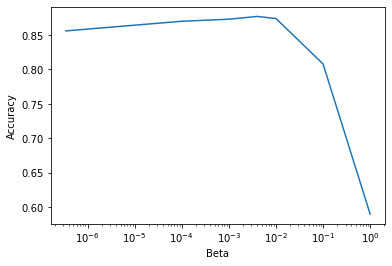

In [40]:
betas_x = [1/TOTAL_VOCAB, .0001, .001, .004, .01, .1, 1]
accuracies_y = [.856, .87, .873, .877, .874, .808, .59]

plt.semilogx(betas_x, accuracies_y)
plt.xlabel('Beta')
plt.ylabel('Accuracy')